### In this notebook, we generate mock observations according to a given distribution of physical parameters. Then we try to recover the underlying distribution. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import pickle
import corner
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

import torch
from torch import nn, Tensor, optim, FloatTensor
from torch.distributions import MultivariateNormal
from geomloss import SamplesLoss
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed/')
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.speculator import SuperSpeculator, StandardScaler
import popsed
popsed.set_matplotlib(style='JL', usetex=False, dpi=80)
from popsed import prior

Input parameters : logmstar, kappa1_sfh, kappa2_sfh, kappa3_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index, redshift


**Input parameters : logmstar, InvSigmoid(kappa1_sfh), InvSigmoid(kappa2_sfh), InvSigmoid(kappa3_sfh), log10(fburst), log10(tburst), logzsol, log10(dust1), log10(dust2), dust_index, log10(redshift)**

We still need penalty on logzsol and dust_index

(10 params)

beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh = Transform(kappa1_sfh, kappa2_sfh, kappa3_sfh)

In [3]:
wave = np.load('./train_sed_NMF/nmf_seds/fsps.wavelength.npy')
speculator = SuperSpeculator(
    speculators_dir=[f'./train_sed_NMF/best_emu/speculator_best_recon_model_NMF.emu_{i_bin}.pkl' for i_bin in range(0, 5)], 
    str_wbin=[
              '.w1000_2000',
              '.w2000_3600', 
              '.w3600_5500', 
              '.w5500_7410', 
              '.w7410_60000'],
    wavelength=wave, 
    params_name=['kappa1_sfh', 'kappa2_sfh', 'kappa3_sfh', 
                 'fburst', 'tburst', 'logzsol', 'dust1', 'dust2', 
                 'dust_index', 'redshift', 'logm'], 
    device='cuda')

filters = ['sdss_{0}0'.format(b) for b in 'ugriz']
noise = 'nsa'
noise_model_dir = './noise_model/nsa_noise_model_mag.npy'

#### Generate mock params

kappa1_sfh, kappa2_sfh, kappa3_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index, redshif, logmstar, 

In [4]:
def gen_truth(N_samples=5000):
    ncomp = 4
    priors = prior.load_priors([
            # Log stellar mass, in M_sun
            prior.GaussianPrior(10.5, 0.4, label='logm'),
            # flat dirichilet priors for SFH
            prior.TruncatedNormalPrior(0, 1, 0.5, 0.1), 
            prior.TruncatedNormalPrior(0, 1, 0.5, 0.1), 
            prior.TruncatedNormalPrior(0, 1, 0.5, 0.1), 
    #         prior.FlatDirichletPrior(ncomp, label='beta'),
            # uniform priors on the mass fraction of burst
            prior.TruncatedNormalPrior(0, 0.6, 0.2, 0.1, label='fburst'),
            # uniform priors on star-burst lookback time
            prior.TruncatedNormalPrior(1e-2, 13.27, 5, 1.5, label='tburst'),
            # uniform priors on log-metallicity, absolute Z
            prior.TruncatedNormalPrior(-2.6, 0.3, -1, 0.3, label='logzsol'),
            # uniform priors on dust1
            prior.TruncatedNormalPrior(0., 3., 0.6, 0.3, label='dust1'),
            # uniform priors on dust2
            prior.TruncatedNormalPrior(0., 3., 0.6, 0.3, label='dust2'),
            # uniform priors on dust_index
            prior.TruncatedNormalPrior(-3., 1., -1, 0.3, label='dust_index'),
            # uniformly sample redshift
            prior.TruncatedNormalPrior(0., 1.5, 0.08, 0.05, label='redshift')
        ])
    
    _thetas_unt = np.array([priors.sample() for i in range(N_samples)])
    _thetas = np.hstack([_thetas_unt[:, 0:1], 
               prior.FlatDirichletPrior(4).transform(_thetas_unt[:, 1:4]), 
               _thetas_unt[:, 4:]])
    
    return _thetas, _thetas_unt

In [5]:
_thetas, _thetas_unt = gen_truth(N_samples=10000)

In [7]:
from popsed.nde import transform_nmf_params, inverse_transform_nmf_params

kappa1_sfh, kappa2_sfh, kappa3_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index, redshift, logmstar

In [8]:
Y_truth = np.hstack([_thetas_unt[:, 1:], # params taken by emulator, including redshift (for t_age)
                     _thetas_unt[:, 0:1], # stellar mass
                    ])
Y_truth = torch.Tensor(Y_truth).to('cuda')
Y_truth_tr = transform_nmf_params(Y_truth) # transform [0,1] to [-inf,0] using log10

X_data = speculator._predict_mag_with_mass_redshift_batch(Y_truth, filterset=filters,
                                                          noise=noise,
                                                          noise_model_dir=noise_model_dir)
flag = ~(torch.isnan(X_data).any(dim=1) | torch.isinf(X_data).any(dim=1))
flags = [((Y_truth[:, i] < speculator.bounds[i, 1]) & (Y_truth[:, i] > speculator.bounds[i, 0])).cpu().numpy()
         for i in range(len(speculator.bounds))]
flag = flag.cpu().numpy() & np.array(flags).all(axis=0)
print('Number of bad photometry:', np.sum(~flag))
X_data = X_data[flag].detach()
Y_truth = Y_truth[flag]

Number of bad photometry: 0


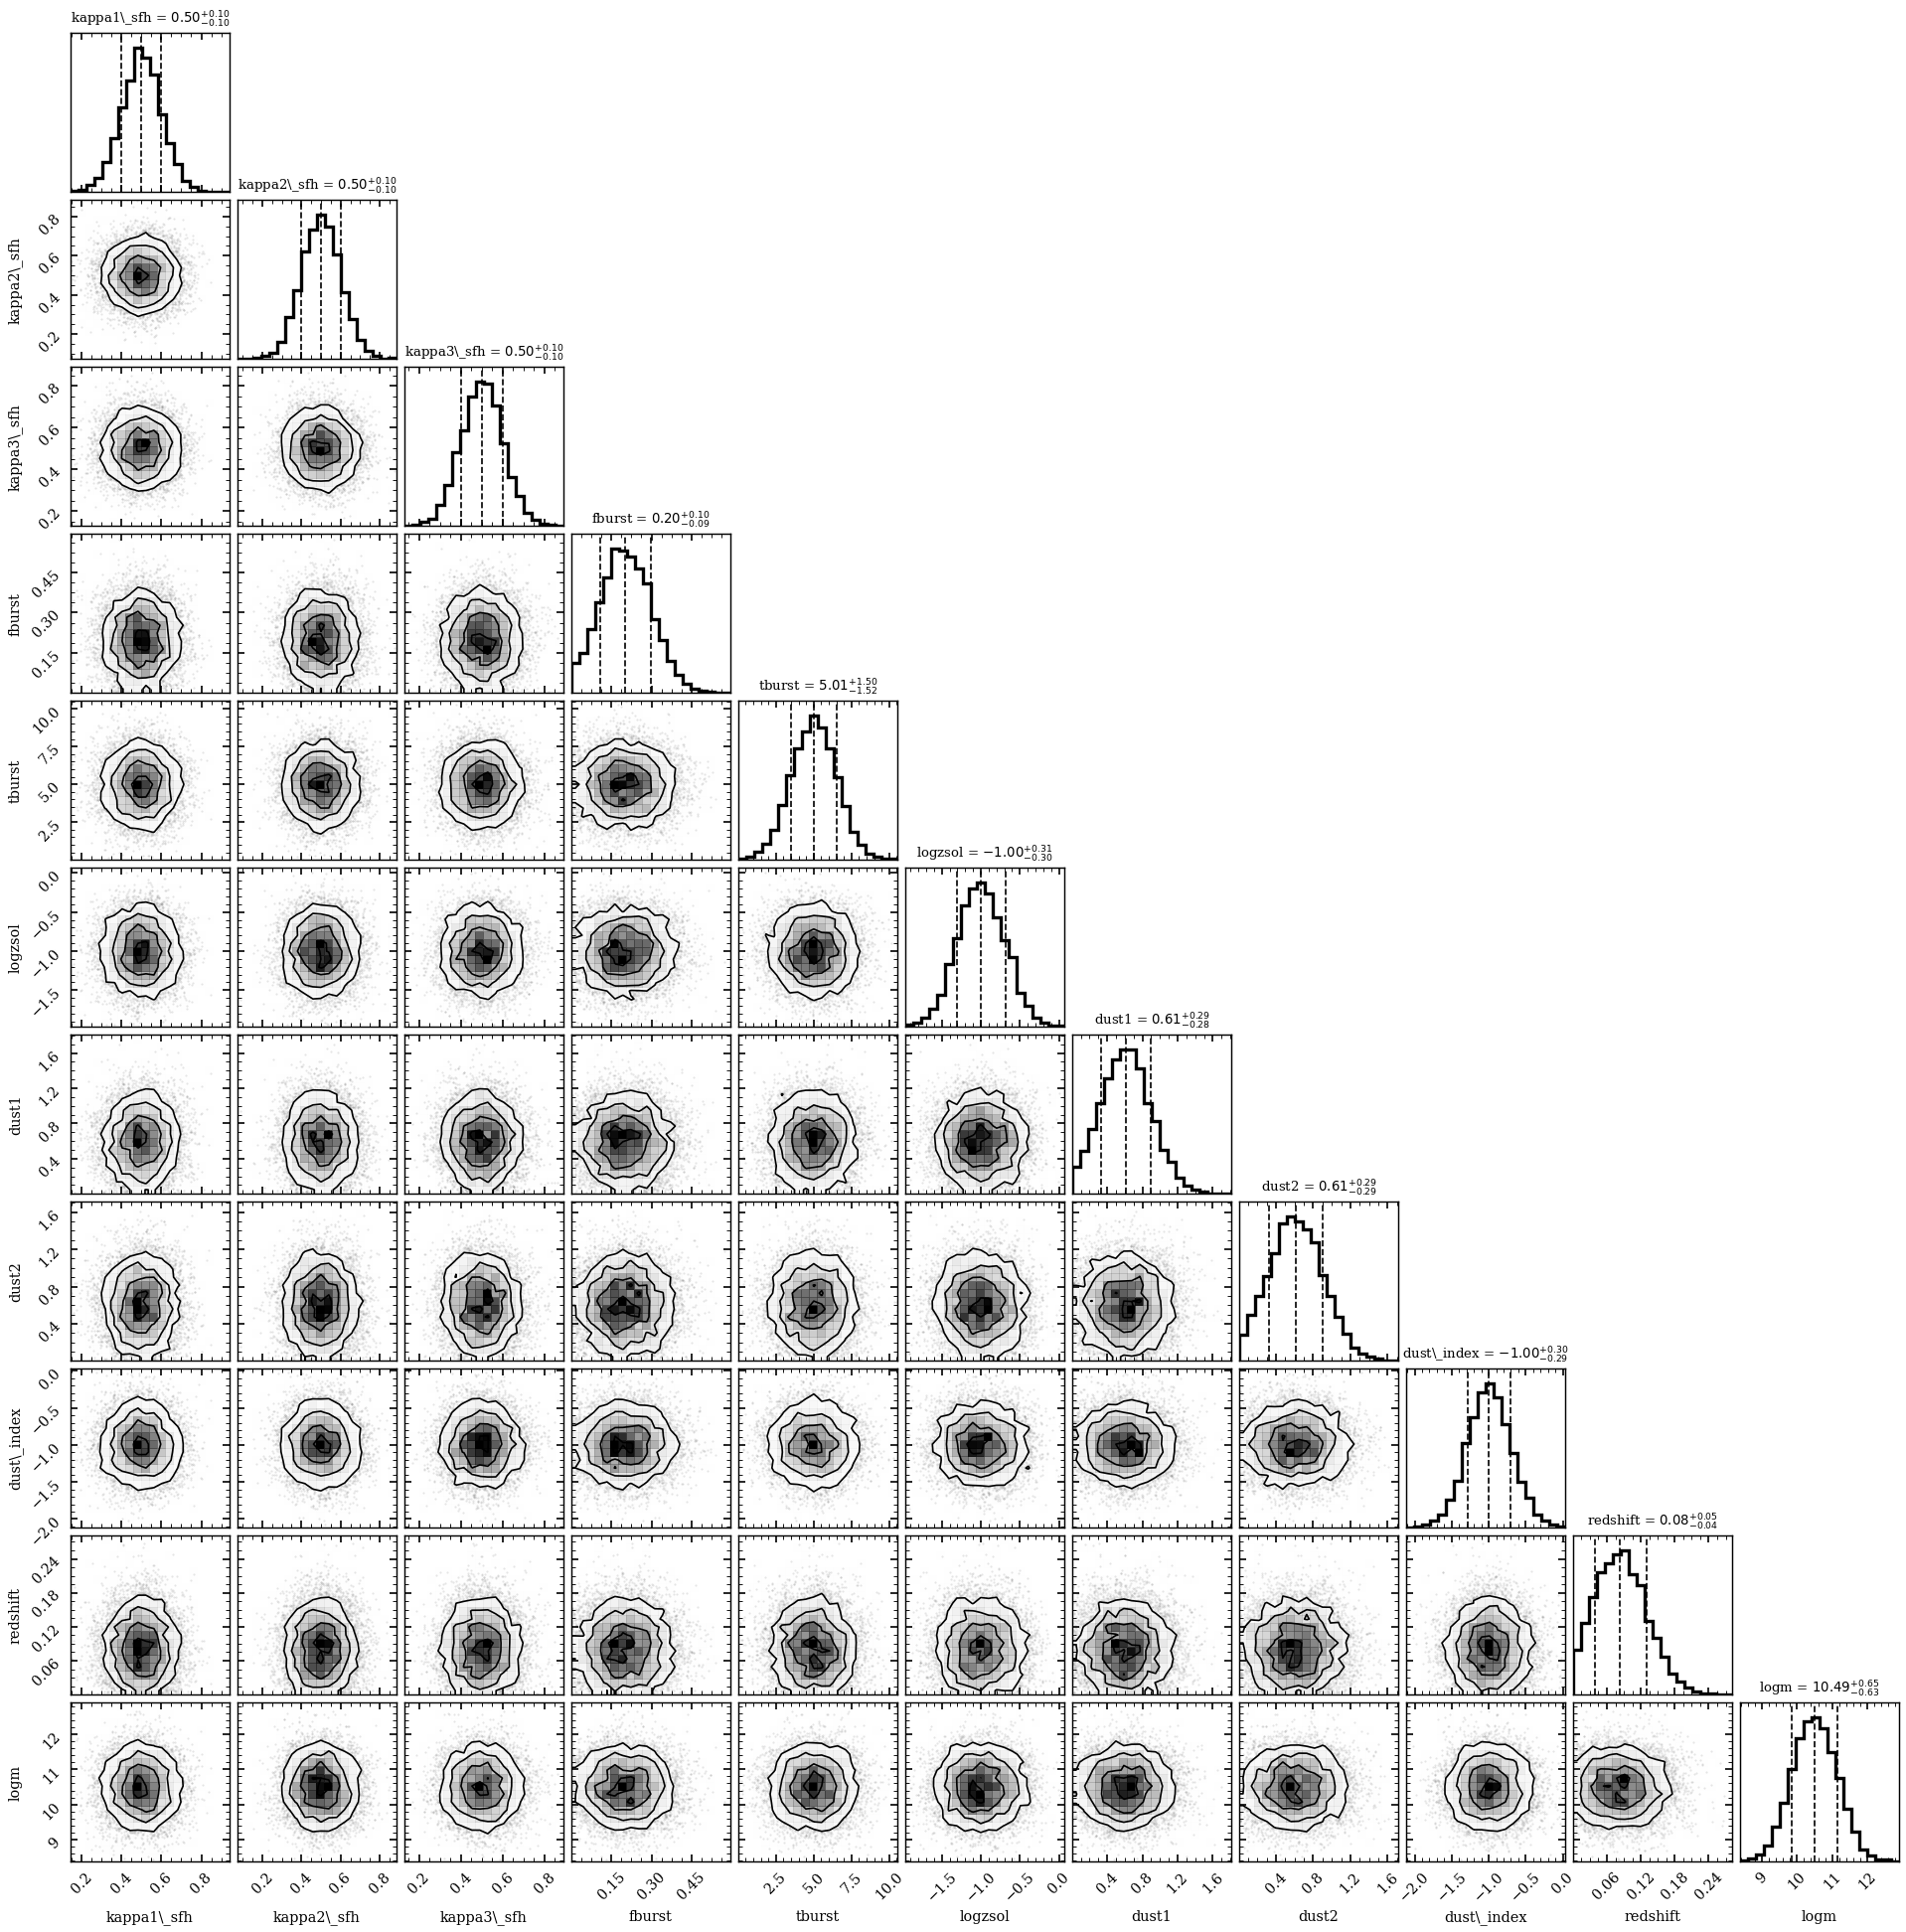

In [44]:
figure = corner.corner(Y_truth.cpu().detach().numpy(), 
                       quantiles=[0.16, 0.5, 0.84], 
                       labels=[key.replace('_', '\_') for key in speculator.params_name],
                       smooth=0.3,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

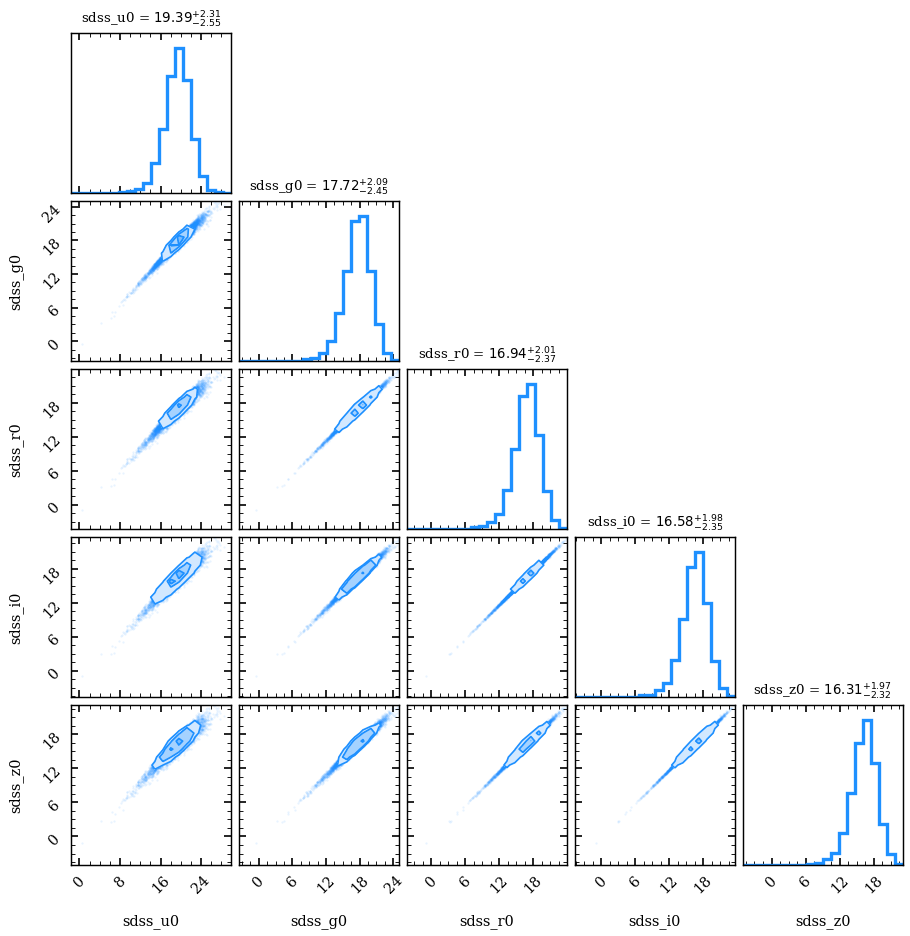

In [63]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Noise-less photometry')
b_line = mlines.Line2D([], [], color='dodgerblue', label=r'Noisy photometry')

labels = filters # [f'sdss\_{f}0' for f in 'ugriz']

figure = corner.corner(X_data.cpu().detach().numpy()[:, :], 
                       color='dodgerblue', labels=labels,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.1, fill_contours=True,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12},
                       hist_kwargs={'density': True})

# nf_plot = corner.corner(X_data.cpu().detach().numpy()[:, :], 
#                         color='dodgerblue', fig=figure, labels=labels,
#                         #quantiles=[0.16, 0.5, 0.84], 
#                         smooth=0.7, fill_contours=True,
#                         show_titles=True, 
#                         title_kwargs={"fontsize": 12},
#                         hist_kwargs={'density': True})

# ax = nf_plot.get_axes()[4]
# ax.legend(handles=[k_line, b_line], fontsize=15)#, bbox_to_anchor=(0., 1.0, 1., .0))

In [11]:
# X_train, X_vali, Y_train, Y_vali = train_test_split(X_data, Y_truth, test_size=0.1)
X_train, X_vali, Y_train, Y_vali = train_test_split(X_data, Y_truth_tr, test_size=0.1)

kappa1_sfh, kappa2_sfh, kappa3_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index, redshift, logmstar

In [71]:
from popsed.speculator import StandardScaler
from popsed.nde import WassersteinNeuralDensityEstimator
from geomloss import SamplesLoss

seed = 20
np.random.seed(seed)

_bounds = speculator.bounds.copy()
for i in range(3):
    _bounds[i] = [0.1, 0.9]

_bounds[6:8] = [1e-2, 3]
_bounds[3] = [0.001, 0.999] # fburst
_bounds[-2] = [1e-3, 0.3] # redshift
_bounds[-1] = [8, 12] # log_m
_bounds = (transform_nmf_params(torch.Tensor(_bounds).T).T).cpu().numpy()

NDE_theta = WassersteinNeuralDensityEstimator(method='nsf',
                                              name='NMF',
                                              num_transforms=15,  # 10
                                              num_bins=5,  # how smashed it is. 10
                                              hidden_features=50,  # 120,
                                              seed=seed,
                                              output_dir=None,
                                              initial_pos={'bounds': _bounds,
                                                           'std': [0.3, 0.3, 0.3,  # sfh
                                                                   0.3, 5,  # burst
                                                                   0.5,  # logzsol
                                                                   0.6, 0.6, 0.6,  # dust
                                                                   0.2, 0.6],  # redshift and log_m
                                                           },
                                              normalize=False,
                                              regularize=True,
                                             )
NDE_theta.build(
    Y_train,
    X_train,
    filterset=filters,
    optimizer='adam')
NDE_theta.load_validation_data(X_vali)
NDE_theta.bounds = speculator.bounds
NDE_theta.params_name = speculator.params_name

[ 0.38728619  1.74773257  1.7205617  -0.55284205 -1.88792146 -0.59390298
 -1.06196139 -0.71558551 -0.36819414 -2.5198095   9.08926561]


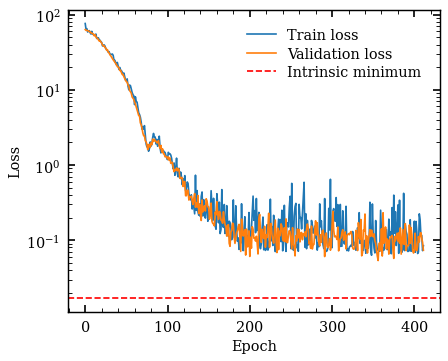

In [17]:
NDE_theta.plot_loss()
plt.yscale('log')

In [18]:
NDE_theta.vali_loss_history[-1]

0.07338796555995941

In [19]:
print('Best epoch:', NDE_theta.best_loss_epoch)
print('Best train loss:', NDE_theta.train_loss_history[NDE_theta.best_loss_epoch - 1])
print('Best vali loss:', NDE_theta.vali_loss_history[NDE_theta.best_loss_epoch - 1])

# NDE_theta.best_model.goodness_of_fit(Y_truth, p=1)
# NDE_theta.goodness_of_fit(Y_truth, p=1)

Best epoch: 357
Best train loss: 0.07613196223974228
Best vali loss: 0.053597576916217804


In [16]:
NDE = pickle.load(open('./NDE/NMF/nde_theta_NMF_sdss_noise_large/nde_theta_best_loss_nsf_20.pkl', 'rb'))
print('Best epoch:', NDE.best_loss_epoch)
print('Best train loss:', NDE.train_loss_history[NDE.best_loss_epoch - 1])
print('Best vali loss:', NDE.vali_loss_history[NDE.best_loss_epoch - 1])

Best epoch: 631
Best train loss: 0.07010968774557114
Best vali loss: 0.03985389322042465


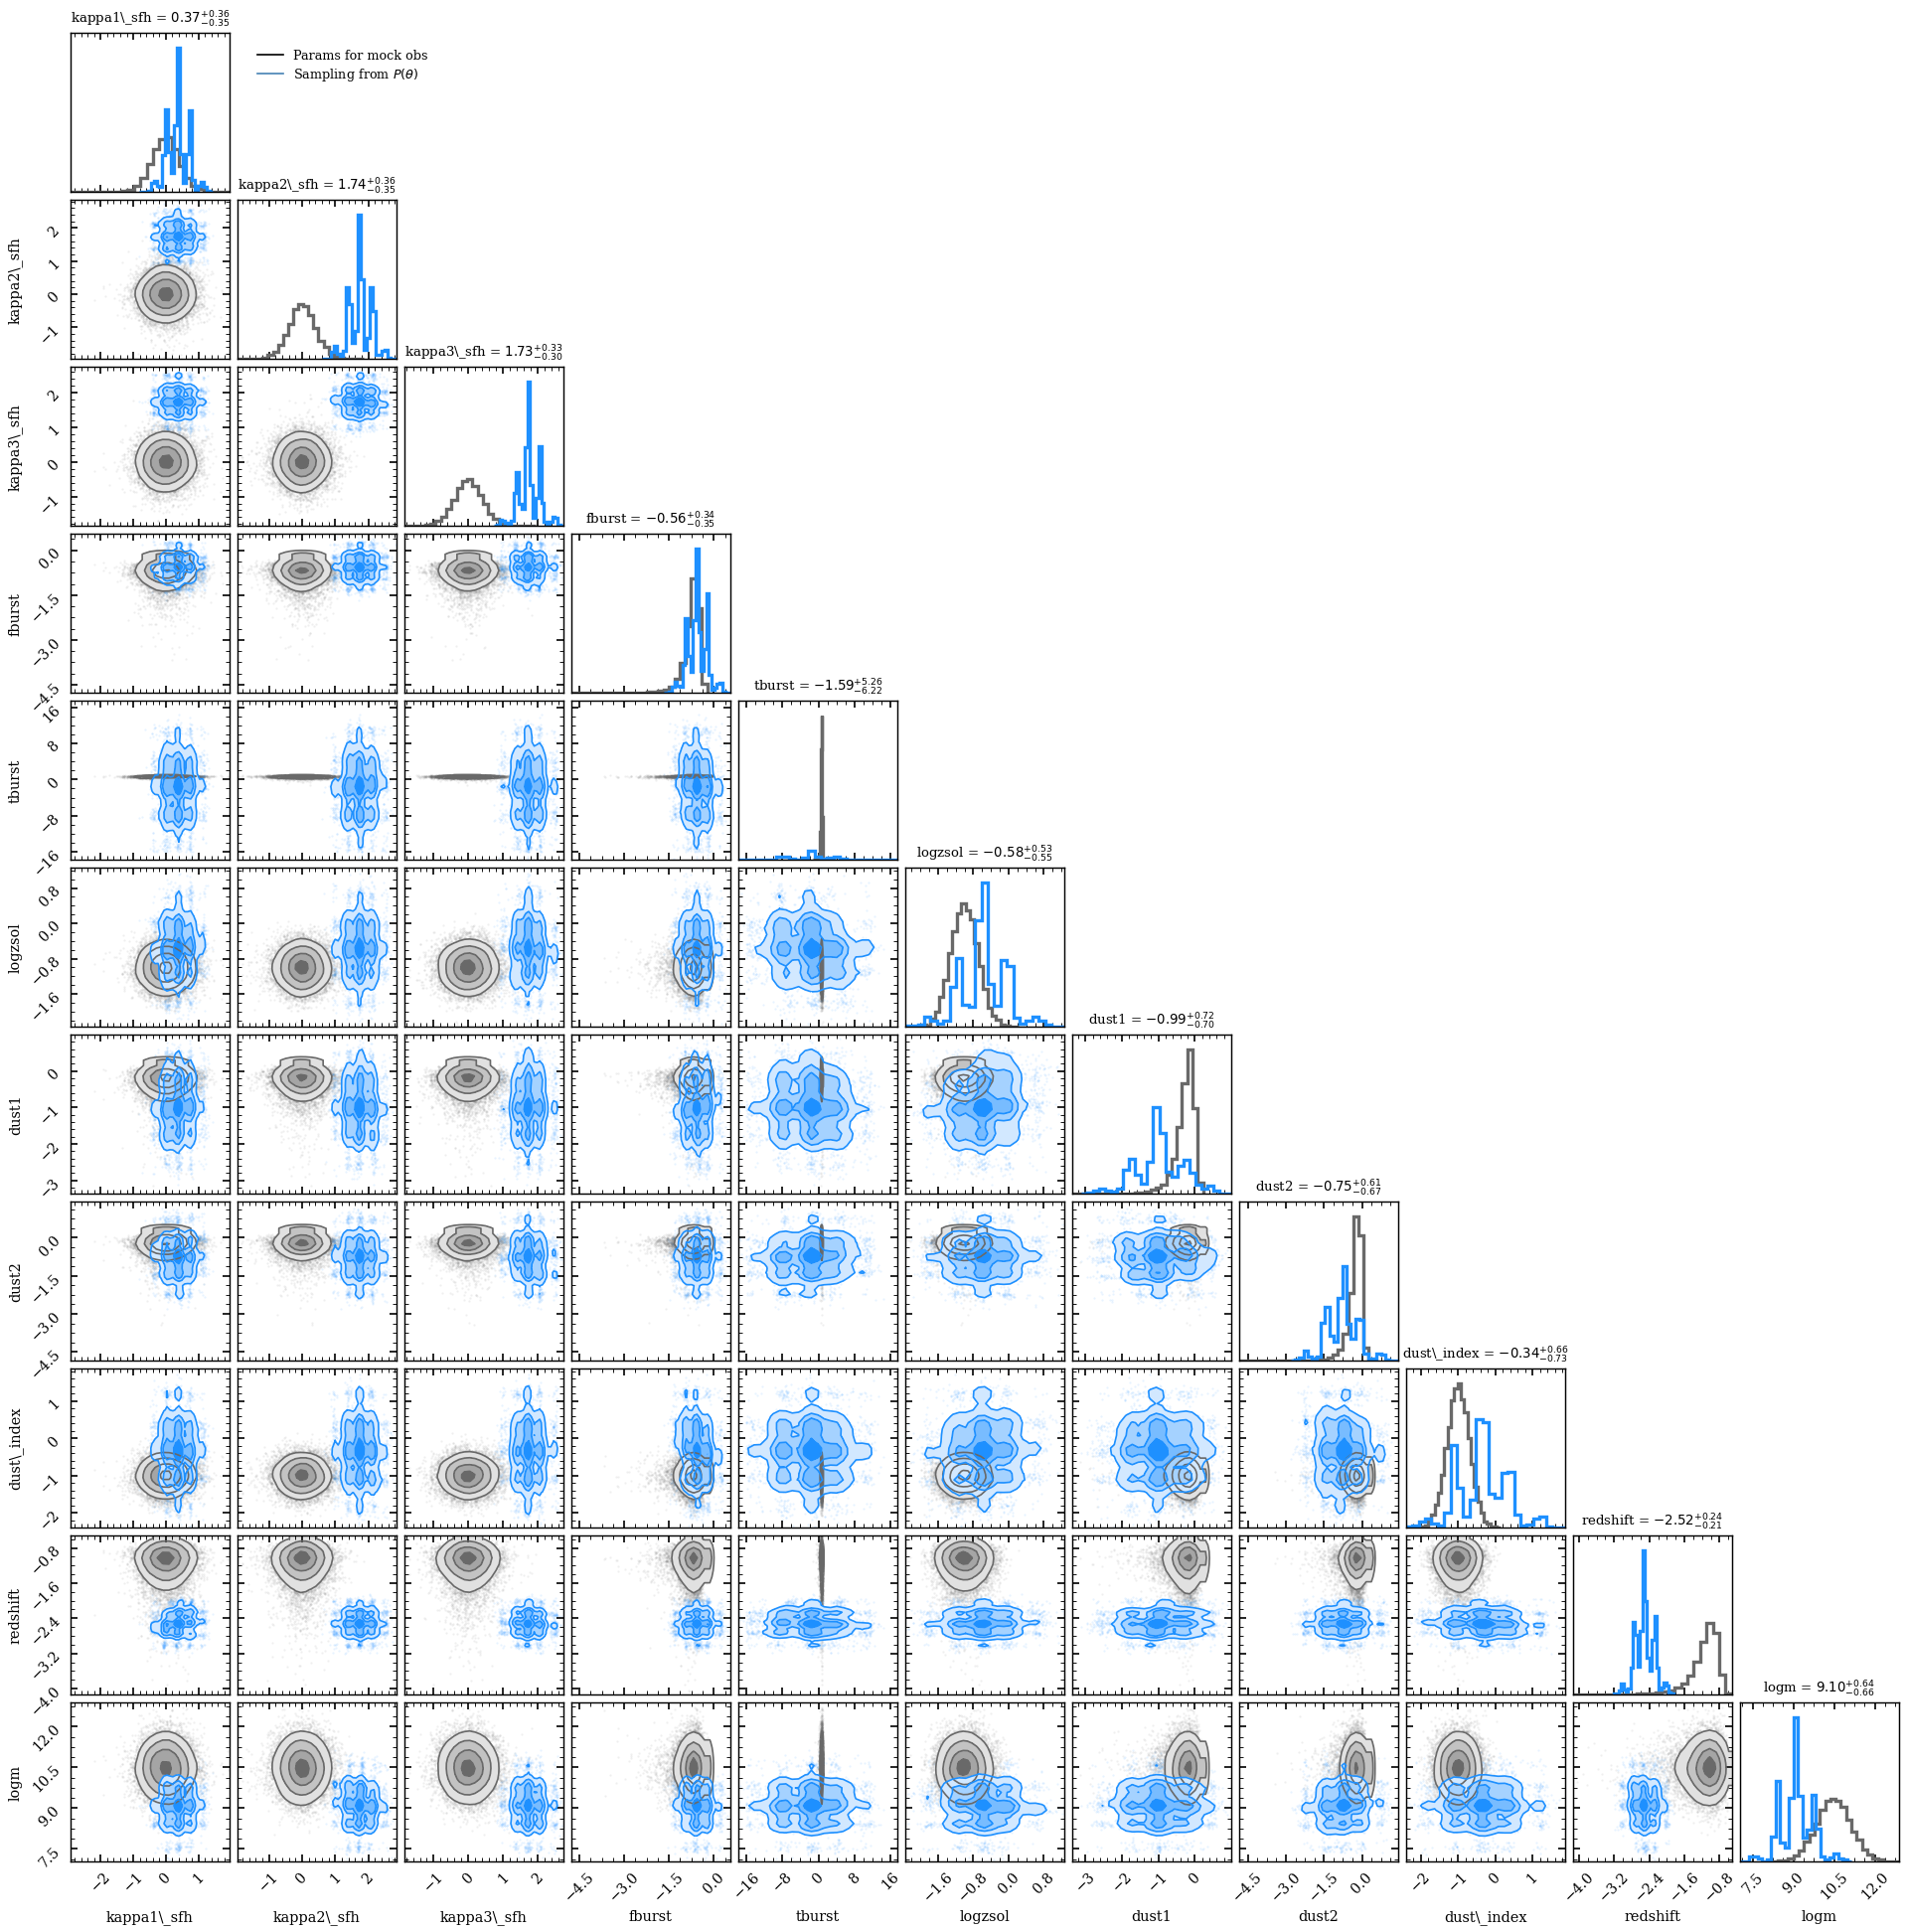

In [19]:
samples = NDE_theta.sample(5000)
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Params for mock obs')
b_line = mlines.Line2D([], [], color='steelblue', label=r'Sampling from $P(\theta)$')

labels = [key.replace('_', '\_') for key in speculator.params_name]

figure = corner.corner(Y_truth_tr.cpu().detach().numpy(), 
                       color='dimgray', labels=labels, bins=25,
                       smooth=1, fill_contours=True,
                       show_titles=True, title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

nf_plot = corner.corner(samples.cpu().detach().numpy(), 
                  fig=figure, labels=labels, bins=25,
                  color='dodgerblue',
                  smooth=1, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True})

ax = nf_plot.get_axes()[1]
ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

In [21]:
# samples = NDE_theta.sample(5000)
# import matplotlib.lines as mlines
# k_line = mlines.Line2D([], [], color='k', label='Params for mock obs')
# b_line = mlines.Line2D([], [], color='steelblue', label=r'Sampling from $P(\theta)$')

# labels = [key.replace('_', '\_') for key in speculator.params_name]

# figure = corner.corner(Y_truth.cpu().detach().numpy(), 
#                        color='dimgray', labels=labels, bins=25,
#                        #quantiles=[0.16, 0.5, 0.84], 
#                        smooth=1, fill_contours=True,
#                        show_titles=True, title_kwargs={"fontsize": 12}, 
#                        hist_kwargs={'density': True})

# nf_plot = corner.corner(inverse_transform_nmf_params(samples).cpu().detach().numpy(), 
#                   fig=figure, labels=labels, bins=25,
#                   color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
#                   smooth=1, fill_contours=True,
#                   show_titles=True, title_kwargs={"fontsize": 12}, 
#                         hist_kwargs={'density': True})

# ax = nf_plot.get_axes()[1]
# ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

0 5000
>40 0


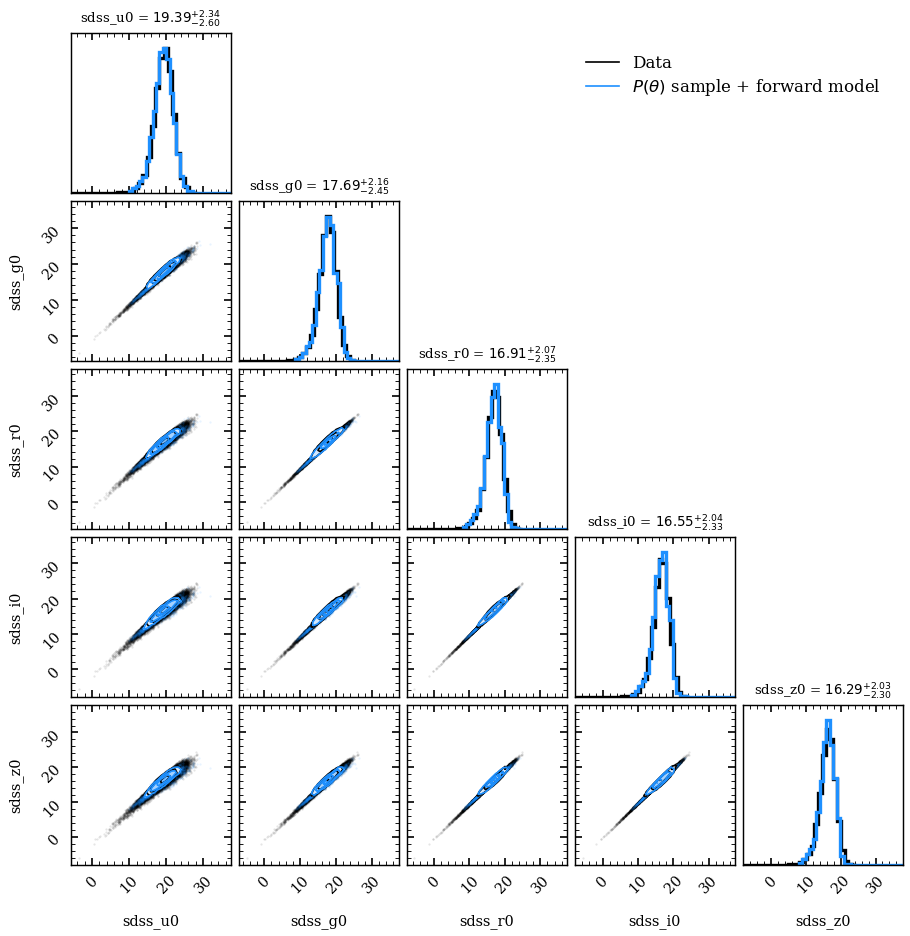

In [22]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Data')
#r_line = mlines.Line2D([], [], color='tomato', label='NDE for the data')
b_line = mlines.Line2D([], [], color='dodgerblue', label=r'$P(\theta)$ sample + forward model')

labels = filters

figure = corner.corner(X_data.cpu().detach().numpy(), 
                       color='k', labels=labels, bins=30,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.4, fill_contours=True,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

mags = speculator._predict_mag_with_mass_redshift(samples,#inverse_transform_nmf_params(samples),
                                                  filterset=filters,
                                                  noise=noise,
                                                  noise_model_dir=noise_model_dir,
                                                  ).cpu().detach().numpy()
print(np.isnan(mags).any(axis=1).sum(), len(mags))
print('>40', np.any(mags > 40, axis=1).sum())
mags = mags[~(np.isinf(mags).any(axis=1)| np.isnan(mags).any(axis=1))]
mags = mags[~np.any(mags > 40, axis=1)]
nf_plot = corner.corner(mags, 
                  fig=figure, labels=labels, bins=30,
                        #range=[[14, 25]] * 5,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.4, fill_contours=True,
                  show_titles=False, 
                        title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

ax = nf_plot.get_axes()[4]
ax.legend(handles=[k_line, b_line], fontsize=15)#, bbox_to_anchor=(0., 1.0, 1., .0))

In [166]:
_samples_unt = inverse_transform_nmf_params(samples).detach().cpu().numpy()
_samples = np.hstack([_samples_unt[:, -1:], 
               prior.FlatDirichletPrior(4).transform(_samples_unt[:, :3]), 
               _samples_unt[:, 3:-1]])

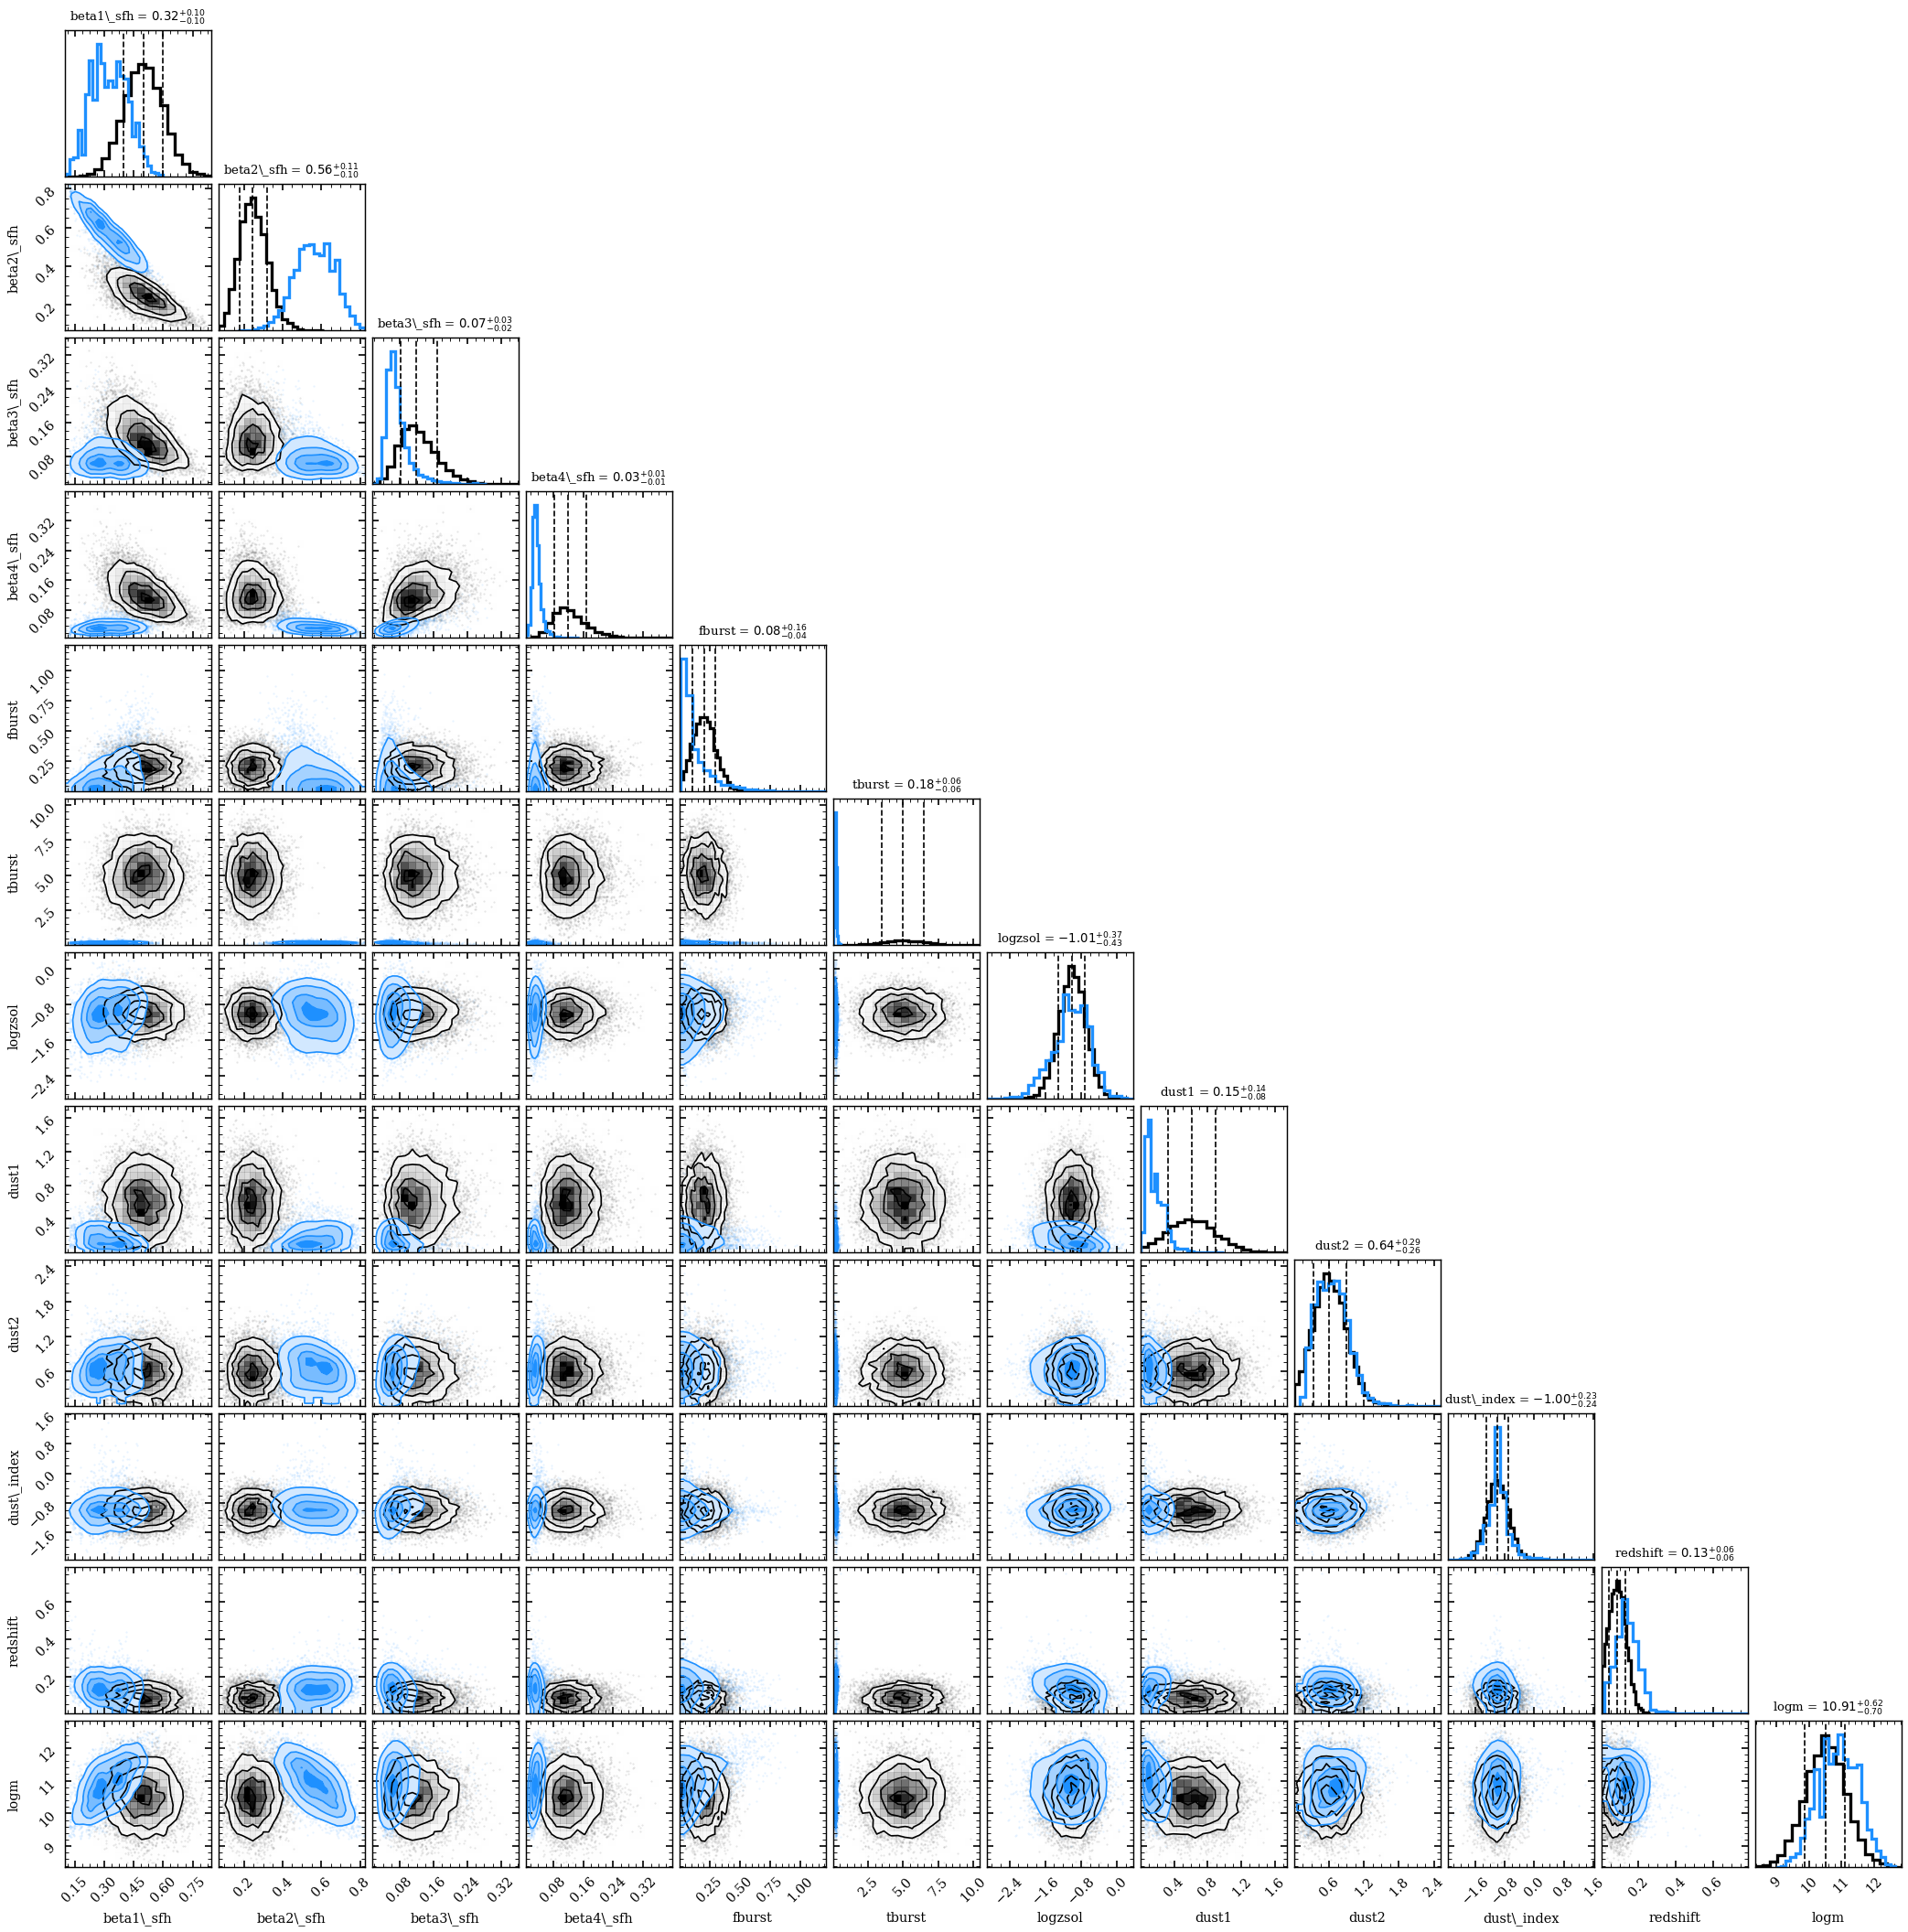

In [168]:
_labels = [f'beta{i}_sfh' for i in range(1,5)] + speculator.params_name[3:]
_labels = [key.replace('_', '\_') for key in _labels]


# Distribution of beta coeffs
y_truth_trans = np.hstack([_thetas[:, 1:], # params taken by emulator, including redshift (for t_age)
                           _thetas[:, 0:1], # stellar mass
                    ])

figure = corner.corner(y_truth_trans, 
                       quantiles=[0.16, 0.5, 0.84], 
                       labels=_labels,
                       smooth=0.3,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

y_truth_trans = np.hstack([_samples[:, 1:], # params taken by emulator, including redshift (for t_age)
                           _samples[:, 0:1], # stellar mass
                    ])

nf_plot = corner.corner(y_truth_trans, 
                  fig=figure, labels=_labels, bins=25,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=1, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True})

# ax = nf_plot.get_axes()[1]
# ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

In [33]:
from torch.utils.data import DataLoader

In [72]:
n_samples = 1000

L = SamplesLoss(loss="sinkhorn", **{'p': 1, 'blur': 0.1, 'scaling': 0.8})

In [74]:
NDE_theta.optimizer.param_groups[0]['lr'] = 1e-6
NDE_theta.optimizer.zero_grad()
loss, bad_ratio = NDE_theta._get_loss_NMF(NDE_theta.X.detach(), speculator, n_samples,
                                 noise, None, noise_model_dir, L, regularize=NDE_theta.regularize)
print(loss, bad_ratio)
loss.backward()
NDE_theta.optimizer.step()
#     NDE_theta.sample(1)

tensor(nan, device='cuda:0', grad_fn=<AddBackward0>) tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)


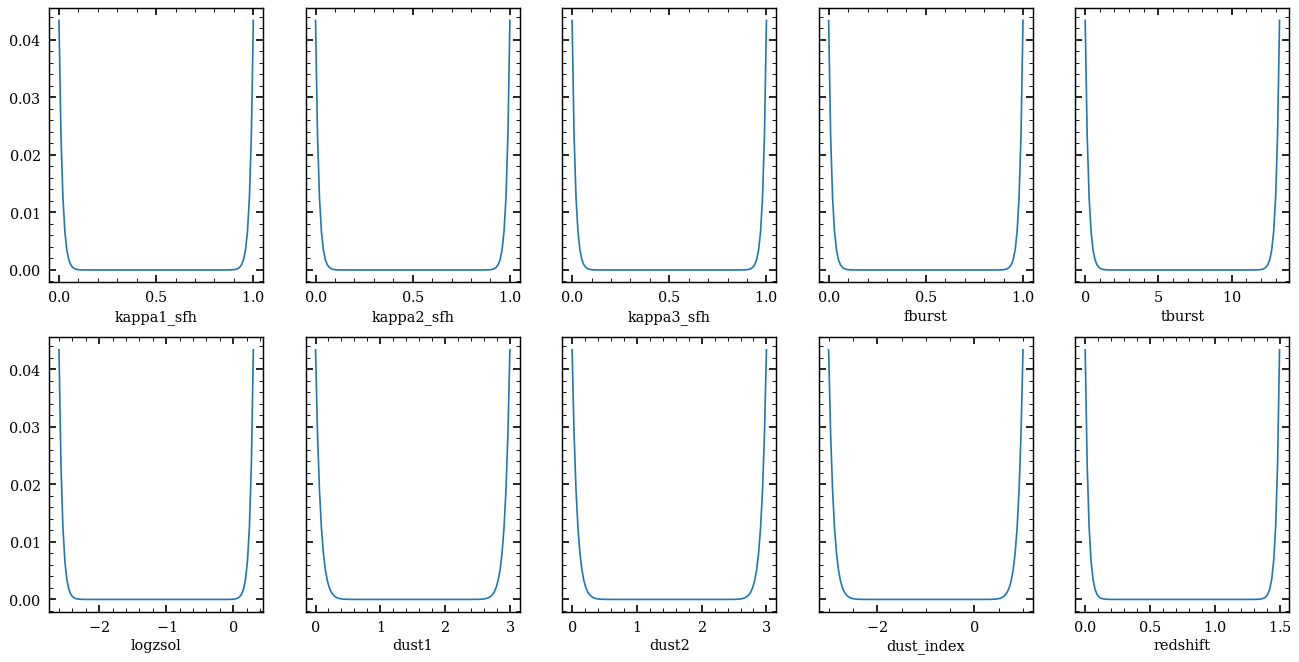

In [209]:
#### Plot the penalty

from popsed.nde import fuzzy_logic_prior

bounds = torch.Tensor(NDE_theta.bounds)

powers = NDE_theta.penalty_powers # [10] * 11
# [50] * 3 + [50] * 2 + [50] + [30] * 3 + [50] * 2
width = (bounds[:, 1] - bounds[:, 0]) / 2
loc = (bounds[:, 1] + bounds[:, 0]) / 2
index = torch.ones_like(loc) * 3

fig, axes = plt.subplots(2, 5, figsize=(20, 10), sharey=True)
for i in range(10):
    plt.sca(axes[i//5, i%5])
    par = torch.linspace(*bounds[i], 100)
    _penalty = fuzzy_logic_prior(par, loc[i], 10 ** (index[i] / powers[i]) * width[i], powers[i])
    plt.plot(par.cpu().numpy(), _penalty.cpu().numpy())
    plt.xlabel(NDE_theta.params_name[i])
    
plt.subplots_adjust(hspace=0.2)

kappa1_sfh, kappa2_sfh, kappa3_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index, redshift, logmstar